In [1]:
from numpy import loadtxt
import numpy as np
import matplotlib.pyplot as plt
from sqlite3 import connect
import pandas as pd

In [2]:
command = f"""SELECT Records.RSN,Records.MW,Records.FaultType,Records.Rjb,Records.VS30,SpectralAccelerations.SRSS FROM Records INNER JOIN SpectralAccelerations ON Records.RSN = SpectralAccelerations.RSN"""
db = connect('D:\Projects\SP_Docker\SoilPrime\Additionals\Peer.db')
cursor = db.cursor()
df = pd.read_sql(command, db)
toArray = lambda x: np.reshape(
            np.fromstring(x[1:-1], dtype=float, sep=" "), (1, 300)
        )[0]
df["SRSS"] = df["SRSS"].apply(toArray)

In [63]:
x = df.iloc[:,1:-1].values
y = []
for i in df.iloc[:,-1].values:
    y.append(list(i))
y = np.array(y)

In [64]:
#Label and one hot encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
le = LabelEncoder()
le_col = 1
x[:,le_col] = le.fit_transform(x[:,le_col])
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [le_col])], remainder='passthrough')
x = np.array(ct.fit_transform(x))

In [67]:
#Standart scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x = sc.fit_transform(x)

In [68]:
#train and test spliting
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [66]:
#ANN modeling
import tensorflow as tf
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=x.shape[1], activation='relu'))
ann.add(tf.keras.layers.Dense(units=x.shape[1]*2, activation='relu'))
ann.add(tf.keras.layers.Dense(units=x.shape[1]*4, activation='relu'))
ann.add(tf.keras.layers.Dense(units=x.shape[1]*8, activation='relu'))
ann.add(tf.keras.layers.Dense(units=x.shape[1]*16, activation='relu'))
ann.add(tf.keras.layers.Dense(units=300, activation='relu'))
ann.compile(optimizer="adam",loss="binary_crossentropy",metrics=["mean_squared_error"])
ann.fit(x_train,y_train,batch_size=64,epochs=200)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [47]:
y_pred = ann.predict(x_test)

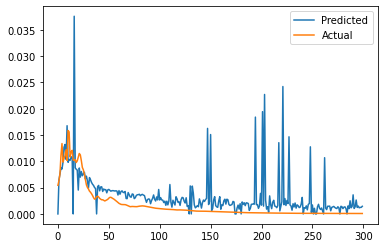

In [50]:
ind = 1
response_pred = y_pred[ind]
response_test = y_test[ind]
plt.plot(response_pred, label="Predicted")
plt.plot(response_test, label="Actual")
plt.legend()
plt.show()
